## Bounding box area versus corners
Using OpenCV to do image processing and get the area of the bounding box. 

In [452]:
%matplotlib inline
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import math
from __future__ import division

In [458]:
def get_boundingBox(image_path, area=False, rotate=True):
    # get the image
    im_in = cv2.imread(image_path,0)

    # Threshold.
    # Set values equal to or above 220 to 0.
    # Set values below 220 to 255.

    th, im_th = cv2.threshold(im_in, 220, 255, cv2.THRESH_BINARY_INV);

    # Copy the thresholded image.
    im_floodfill = im_th.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv

    im_out, contours,hierarchy = cv2.findContours(im_out, 1, 2)
    cnt = contours[0]
    cntArea = cv2.contourArea(cnt)
    
    if rotate:
        # Now get the bounding box
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        if area:
            return rect[1][0] * rect[1][1], int(cntArea)

        return im_out, box
   
    else:
        x,y,w,h = cv2.boundingRect(cnt)
        box = np.array([[x,y],[x,y+h],[x+w, y+h],[x+w,y]])
        
        if area: 
            return w*h, int(cntArea)
        
        return im_out, box
    

### Testing
Testing the bounding box function and printing it out, making sure that the box is correct

0.492214215926


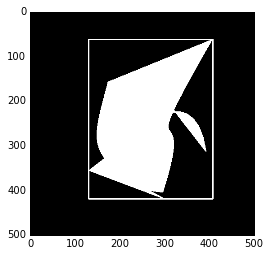

In [453]:
test_image = os.path.join(image_dir, str(7), "LC", "LC6")

# running function
test_box = get_boundingBox(test_image, area=False, rotate=False)

# Show the output
im_out = cv2.drawContours(test_box[0],[test_box[1]],0,(255,255,255),2)
plt.imshow(im_out, cmap = 'gray')

# Get the area
test_box = get_boundingBox(test_image, area=True, rotate=False)
print test_box[1]/test_box[0]

## Comparing all images

Now we can run on all the images, comparing the number of corners to the size of the rotated bounding box

In [429]:
cwd = os.getcwd()
imageStimDir = os.path.join(cwd, "STIMULI", "images")

In [461]:
corners = []
boxArea = []

for numCorners in range(13):
    
    
    LCDir = os.path.join(imageStimDir, str(numCorners), "LC")
    PSDir = os.path.join(imageStimDir, str(numCorners), "PS")
    
    for imageFile in os.listdir(LCDir):
        image_path = os.path.join(LCDir, imageFile)
        
        area = get_boundingBox(image_path, area=True)
        if area[0] <= 0:
            continue
        corners.append(numCorners+1)
        boxArea.append(area[0])

    for imageFile in os.listdir(PSDir):
        image_path = os.path.join(PSDir, imageFile)
        
        area = get_boundingBox(image_path, area=True)
        if area[0] <= 0:
            continue
        corners.append(numCorners+1)
        boxArea.append(area[0])
        
    

### Plotting 
Plotting corners versus bounding box area


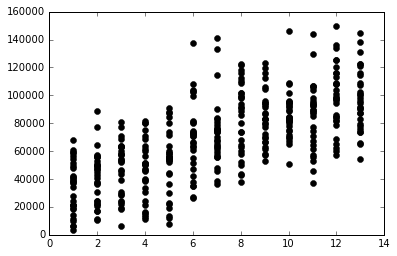

In [462]:
plt.plot(corners, boxArea, 'ko')

## Comparing with a straight bounding rectangle
The rotated rectangle might not be giving us the actual representation that we want. The rotated rectangle is giving a rougher estimate of pure area, and not bounding box. Looking at straight bounding rectangle

In [463]:
corners = []
boxArea = []

for numCorners in range(13):
    
    
    LCDir = os.path.join(imageStimDir, str(numCorners), "LC")
    PSDir = os.path.join(imageStimDir, str(numCorners), "PS")
    
    for imageFile in os.listdir(LCDir):
        image_path = os.path.join(LCDir, imageFile)
        
        area = get_boundingBox(image_path, area=True)
        if area[0] <= 0:
            continue
        corners.append(numCorners+1)
        boxArea.append(get_boundingBox(image_path, area=True, 
                                       rotate=False)[0])

    for imageFile in os.listdir(PSDir):
        image_path = os.path.join(PSDir, imageFile)
        
        area = get_boundingBox(image_path, area=True)
        if area[0] <= 0:
            continue
        corners.append(numCorners+1)
        boxArea.append(get_boundingBox(image_path, area=True, 
                                       rotate=False)[0])

### Plotting 
Plotting corners versus bounding box area


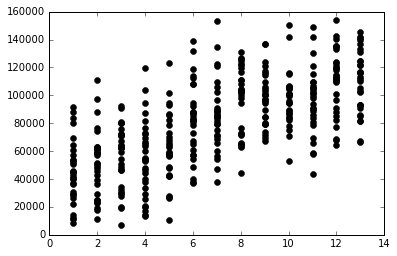

In [464]:
plt.plot(corners, boxArea, 'ko')

## Bounding box:Area of shape versus corners

In [469]:
corners = []
areaRatio = []

for numCorners in range(13):
    
    
    LCDir = os.path.join(imageStimDir, str(numCorners), "LC")
    PSDir = os.path.join(imageStimDir, str(numCorners), "PS")
    
    for imageFile in os.listdir(LCDir):
        image_path = os.path.join(LCDir, imageFile)
        
        area = get_boundingBox(image_path, area=True, rotate=False)
        if area[0] <= 0 or area[1] <= 0:
            continue
        corners.append(numCorners+1)
        areaRatio.append(area[1]/area[0])

    for imageFile in os.listdir(PSDir):
        image_path = os.path.join(PSDir, imageFile)
        
        area = get_boundingBox(image_path, area=True, rotate=False)
        if area[0] <= 0 or area[1] <= 0:
            continue
        corners.append(numCorners+1)
        areaRatio.append(area[1]/area[0])


### Plotting 
Plotting corners versus bounding box area


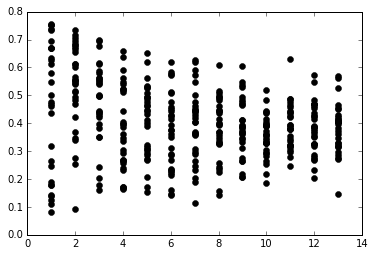

In [470]:
plt.plot(corners, areaRatio, 'ko')